# Exercise 1: Optimize lepton selection

* First, print the distributions of the relevant variables for *all* the Monte Carlo samples (i.e. all the *channels* of the $Z$-boson decay to be studied). Which variables are these? Give sensible ranges to include all the events in the samples (both MC and OPAL data) 
* Do the same for **one** of the OPAL data samples (your lab assistant will decide which one you choose).
* Describe the results.
* Optimize the object selection by applying cuts. Make a strategy on how to proceed to find the optimal selection. which information do you need?
* Determine the efficiency and the amount of background for each $Z$ decay channel. Use the simulated events $e^+e^-$, $\mu^+\mu^-$, $\tau^+\tau^-$ and hadrons ($qq$). Represent the result in a matrix form and think carefully about how you have to correct the measured rates. Don't forget to calculate the errors!
* How do we estimate the statistical fluctuations per bin?

**Import libraries**:

In [1]:
import uproot
import awkward as ak
import mplhep
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

**Open Monte Carlo samples**

We will open data and Monte Carlo samples using **uproot**. Uproot is a reader and a writer of the ROOT file format using only Python and Numpy. Unlike PyROOT and root_numpy, uproot does not depend on C++ ROOT so that no local compilation of the ROOT libraries is needed to access the data.

You can find more info on uproot following the references:
* Github repo: https://github.com/scikit-hep/uproot4
* Tutorial: https://masonproffitt.github.io/uproot-tutorial/
* Video tutorial on uproot and awkward arrays:  https://www.youtube.com/embed/ea-zYLQBS4U 

First, let's specify the folder path for both data and Monte Carlo (MC) samples

In [2]:
path_mc = 'opal_data/mc/'

# Open the files
file_mc_ee = uproot.open(path_mc+'ee.root')
file_mc_mm = uproot.open(path_mc+'mm.root')
file_mc_tt = uproot.open(path_mc+'tt.root')
file_mc_qq = uproot.open(path_mc+'qq.root')


# Name the ttree name
ttree_name = 'myTTree'

# Print list of 'branches' of the TTree (i.e. list of variable names)
variable_names = file_mc_ee[ttree_name].keys()

# Load branches
branches_ee = file_mc_ee[ttree_name].arrays()
branches_mm = file_mc_mm[ttree_name].arrays()
branches_tt = file_mc_tt[ttree_name].arrays()
branches_qq = file_mc_qq[ttree_name].arrays()
branches_tot = ak.concatenate((branches_ee, branches_mm, branches_tt, branches_qq))


# convert data into dictionaries of numpy arrays
array_ee = {}
array_mm = {}
array_tt = {}
array_qq = {}
array_tot = {}

for variable in variable_names:
    array_ee[variable] = ak.to_numpy(branches_ee[variable])
    array_mm[variable] = ak.to_numpy(branches_mm[variable])
    array_tt[variable] = ak.to_numpy(branches_tt[variable])
    array_qq[variable] = ak.to_numpy(branches_qq[variable])
    array_tot[variable] = ak.to_numpy(branches_tot[variable])


# print('These are the different variables: ', variable_names)
# print('E_lep = {0:4.2f} GeV = const.'.format(branches_ee['E_lep'][0]))

In [4]:
print(len(array_ee['Pcharged']), len(array_mm['Pcharged']), len(array_tt['Pcharged']), len(array_qq['Pcharged']))

93802 94381 79214 98563


| Variable name | Description |
| --- | --- | 
| run| Run number |
| event | Event number |
| Ncharged | Number of charged tracks |
| Pcharged | Total scalar sum of track momenta |
| E_ecal| Total energy measured in the electromagnetic calorimeter |
| E_hcal | Total energy measured in the hadronic calorimete |
| E_lep | LEP beam energy (=$\sqrt{s}/2$) |
| cos_thru | cosine of the polar angle between beam axis and thrust axis |
| cos_thet | cosine of the polar angle between incoming positron and outgoing positive particle |


For our statistical analysis the run and event number are not interesting. The beam energy $E_\mathrm{lep}=45.64\,\mathrm{GeV}$ is constant for the data set. The scattering angles will not be used for identifying the channels and are subsect of analysis further below. Therefore we first concentrate only on the subset of variables Ncharged, Pcharged, E_ecal and E_hcal.

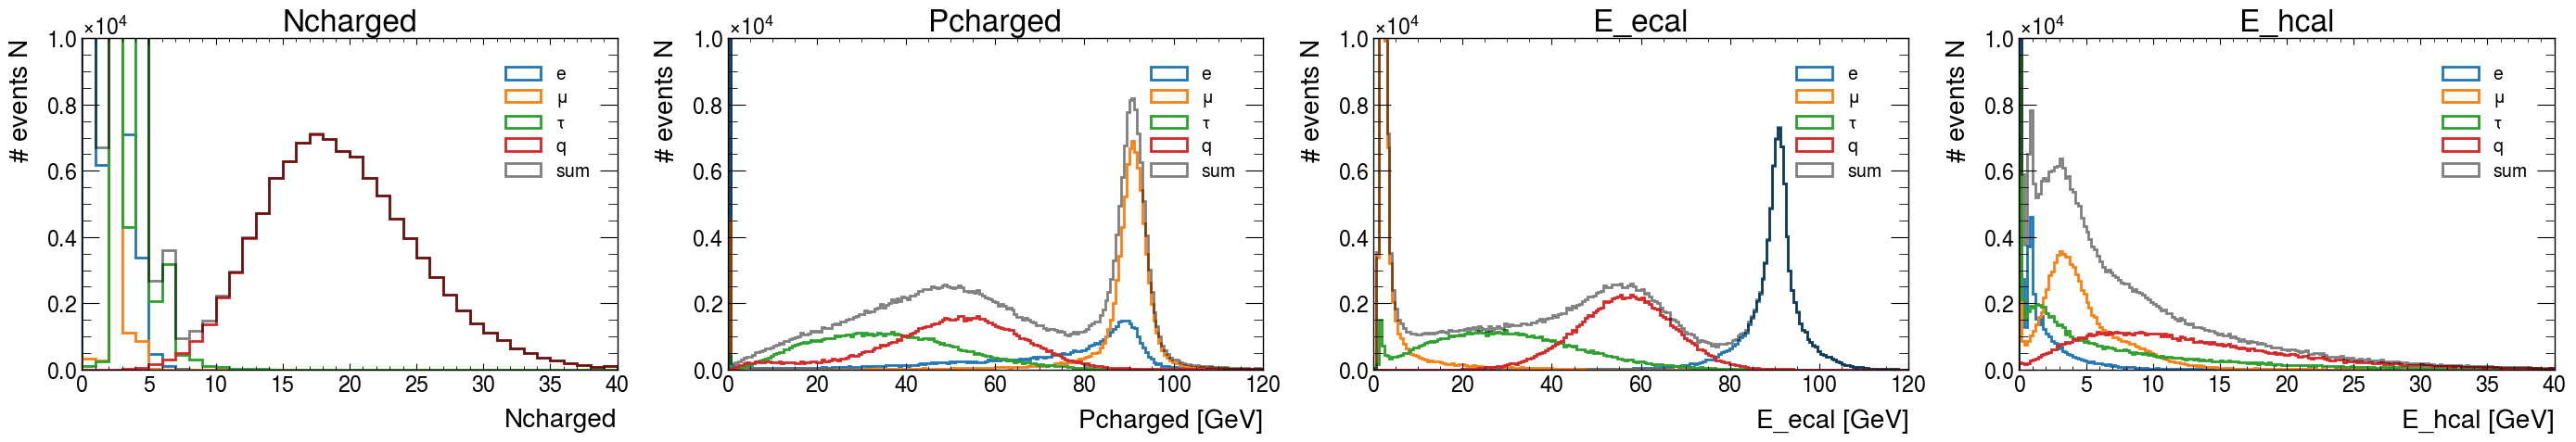

In [5]:
# for now, we are interested only in this subset
variables = variable_names[2:6]
units = ['', ' [GeV]', ' [GeV]', ' [GeV]']  # corresponding units

# bins for histogramms
bins_mc = {'Ncharged' : np.linspace(0, 40, 41),
           'Pcharged' : np.linspace(0, 120, 201),
           'E_ecal' : np.linspace(0, 120, 201),
           'E_hcal' : np.linspace(0, 40, 201)}


# limits for the plots
ylims_mc = [(0, 1e4), (0, 1e4), (0, 1e4), (0, 1e4)]

# plot style of ATLAS
plt.style.use(mplhep.style.ATLAS)


fig, axes = plt.subplots(1, 4, figsize=(28, 5))


for (i, variable) in zip(range(4), variables):
    # plot distributions
    axes[i].hist(array_ee[variable], bins=bins_mc[variable],
                 histtype='step', linewidth=2, label=r'$e$')
    axes[i].hist(array_mm[variable], bins=bins_mc[variable],
                 histtype='step', linewidth=2, label=r'$\mu$')
    axes[i].hist(array_tt[variable], bins=bins_mc[variable],
                 histtype='step', linewidth=2, label=r'$\tau$')
    axes[i].hist(array_qq[variable], bins=bins_mc[variable],
                 histtype='step', linewidth=2, label=r'$q$')
    axes[i].hist(array_tot[variable], bins=bins_mc[variable],
                 histtype='step', linewidth=2, label=r'$sum$',
                 color='black', alpha=0.5)

    # plot settings
    axes[i].set_ylim(ylims_mc[i])
    axes[i].set_title(variable)
    axes[i].set_xlabel(variable + units[i])
    axes[i].set_ylabel(r'# events $N$')
    axes[i].legend()


plt.tight_layout()
plt.show()

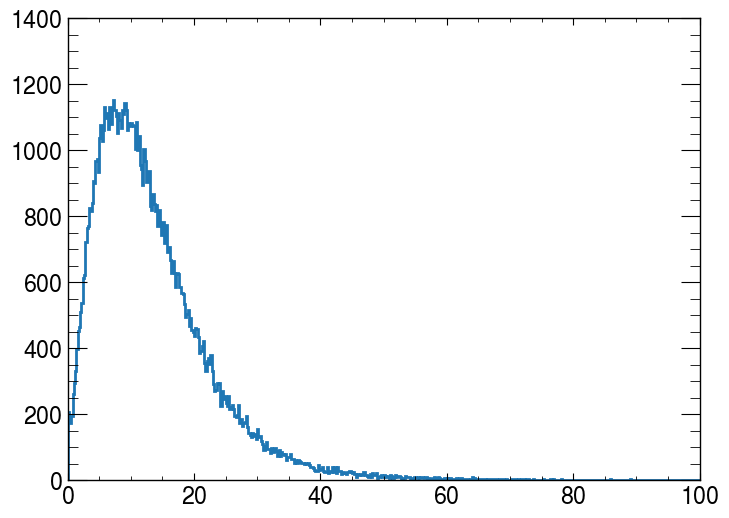

In [66]:
# Testline to have a closer look at certain distributions
variable = 'E_hcal'

plt.hist(ak.to_numpy(branches_qq[variable]), bins=np.linspace(0, 100, 501),
                 histtype='step',  linewidth=2)
# plt.yscale('log')

plt.show()

In the histograms above we see different kind of distributions for different variables and decay channels. Some distributions closely resemble a Gaussian such that a cut can easily be defined via mean and standard deviation. If for example we choose an interval of 3$\sigma$ we keep approximately 99% of the events. Since the distributions partially overlap, this also causes many false positive events. We hope to make the filters unique by applying such cuts on multiple variables.

Other distributions are not easily approximated by a Guassian. These are e.g. the Ncharged curves for $e$, $\mu$ and $\tau$, since they have a small mean. Also Pcharged is problematic since often the momentum is missing in the data (is this interpretation correct?), e.g., for $e$ about 50% of the events have Pcharged=0, while the rest of the distribution is centred at higher values.


All these effects have to be considered to define meaningful cuts. Nevertheless, let us start the analysis by calculating the mean and standard deviation of all distributions.

In [6]:
# data structure for mean values
mean_ee = {}
mean_mm = {}
mean_tt = {}
mean_qq = {}

# data structure for standard deviation
std_ee = {}
std_mm = {}
std_tt = {}
std_qq = {}

# calculate values for all variables
for variable in variables:

    # get array from teh dictionary to shorten code
    stat_array_ee = array_ee[variable]
    stat_array_mm = array_mm[variable]
    stat_array_tt = array_tt[variable]
    stat_array_qq = array_qq[variable]

    # Pcharged exhibits unexpected behavior:
    # a significant number of values is 0.
    # there are few outliers with very high values distorting the statistics
    # therefore consider only 'regular' events to describe the distributions
    if variable == 'Pcharged':
        stat_mask_ee = (array_ee[variable] > 0.)*(array_ee[variable] < 120.)
        stat_mask_mm = (array_mm[variable] > 0.)*(array_mm[variable] < 120.)
        stat_mask_tt = (array_tt[variable] > 0.)*(array_tt[variable] < 120.)
        stat_mask_qq = (array_qq[variable] > 0.)*(array_qq[variable] < 120.)

        stat_array_ee = stat_array_ee[stat_mask_ee]
        stat_array_mm = stat_array_mm[stat_mask_mm]
        stat_array_tt = stat_array_tt[stat_mask_tt]
        stat_array_qq = stat_array_qq[stat_mask_qq]

    # calculate statistics
    mean_ee[variable] = stat_array_ee.mean()
    mean_mm[variable] = stat_array_mm.mean()
    mean_tt[variable] = stat_array_tt.mean()
    mean_qq[variable] = stat_array_qq.mean()

    std_ee[variable] = stat_array_ee.std()
    std_mm[variable] = stat_array_mm.std()
    std_tt[variable] = stat_array_tt.std()
    std_qq[variable] = stat_array_qq.std()

    # print the tables
    print(variable)
    print('    mean  +-   std, [min,      max]')
    print('ee: {0:5.2f} +- {1:5.2f}, [{2:5.2f}, {3:6.2f}]'.format(
            stat_array_ee.mean(), stat_array_ee.std(),
            stat_array_ee.min(), stat_array_ee.max()))
    print('mm: {0:5.2f} +- {1:5.2f}, [{2:5.2f}, {3:6.2f}]'.format(
            stat_array_mm.mean(), stat_array_mm.std(),
            stat_array_mm.min(), stat_array_mm.max()))
    print('tt: {0:5.2f} +- {1:5.2f}, [{2:5.2f}, {3:6.2f}]'.format(
            stat_array_tt.mean(), stat_array_tt.std(),
            stat_array_tt.min(), stat_array_tt.max()))
    print('qq: {0:5.2f} +- {1:5.2f}, [{2:5.2f}, {3:6.2f}]'.format(
            stat_array_qq.mean(), stat_array_qq.std(),
            stat_array_qq.min(), stat_array_qq.max()))
    print('\n')

Ncharged
    mean  +-   std, [min,      max]
ee:  1.65 +-  1.07, [ 0.00,   9.00]
mm:  2.02 +-  0.26, [ 0.00,   6.00]
tt:  2.87 +-  1.30, [ 0.00,  18.00]
qq: 18.88 +-  5.74, [ 3.00,  48.00]


Pcharged
    mean  +-   std, [min,      max]
ee: 72.96 +- 21.67, [ 0.19, 119.97]
mm: 89.30 +-  8.20, [ 0.25, 119.99]
tt: 35.72 +- 16.28, [ 0.16, 119.95]
qq: 49.62 +- 17.19, [ 0.31, 120.00]


E_ecal
    mean  +-   std, [min,      max]
ee: 89.55 +-  6.84, [41.55, 124.32]
mm:  3.66 +-  5.36, [ 0.20,  87.72]
tt: 29.85 +- 16.07, [ 0.63, 101.03]
qq: 56.27 +- 10.80, [14.92, 107.53]


E_hcal
    mean  +-   std, [min,      max]
ee:  0.79 +-  1.89, [ 0.00,  82.45]
mm:  4.52 +-  3.49, [ 0.00,  98.78]
tt:  6.96 +-  8.24, [ 0.00, 110.91]
qq: 13.38 +-  9.24, [ 0.00,  95.67]




### Apply cuts

Apply cuts to the different distributions. Individual notes to the different cut selections are commented.
The general reference where to apply a cut is: mean +- 3 sigma, to include most of all events in our selection.
In cases of specific asymmetric distributions or something similar, a correction by eye is performed.

In [8]:
# definign cuts
cuts_ee = {'Ncharged' : (0, 6),
           'Pcharged' : (mean_ee['Pcharged'] - 3*std_ee['Pcharged'], 100),  # asymmetry of distr. 3σ left, 1-2σ right
           'E_ecal' : (mean_ee['E_ecal'] - 3*std_ee['E_ecal'],
                       mean_ee['E_ecal'] + 3*std_ee['E_ecal']),
           'E_hcal' : (0, mean_ee['E_hcal'] + 3*std_ee['E_hcal'])}

cuts_mm = {'Ncharged' : (0, 4),
           'Pcharged' : (mean_mm['Pcharged'] - 3*std_mm['Pcharged'],
                         mean_mm['Pcharged'] + 3*std_mm['Pcharged']),
           'E_ecal' : (0, mean_mm['E_ecal'] + 3*std_mm['E_ecal']),
           'E_hcal' : (0, mean_mm['E_hcal'] + 3*std_mm['E_hcal'])}

cuts_tt = {'Ncharged' : (0, 7),
           'Pcharged' : (mean_tt['Pcharged'] - 2*std_tt['Pcharged'],
                         mean_tt['Pcharged'] + 3*std_tt['Pcharged']),
           'E_ecal' : (0, mean_tt['E_ecal'] + 3*std_tt['E_ecal']),
           'E_hcal' : (0, mean_tt['E_hcal'] + 3*std_tt['E_hcal'])}

cuts_qq = {'Ncharged' : (4, 39),
           'Pcharged' : (mean_qq['Pcharged'] - 2*std_qq['Pcharged'],
                         mean_qq['Pcharged'] + 2*std_tt['Pcharged']),
           'E_ecal' : (mean_qq['E_ecal'] - 3*std_qq['E_ecal'],
                       mean_qq['E_ecal'] + 3*std_qq['E_ecal']),
           'E_hcal' : (0, mean_qq['E_hcal']+3*std_qq['E_hcal'])}


cuts = {'ee' : cuts_ee,
        'mm' : cuts_mm,
        'tt' : cuts_tt,
        'qq' : cuts_qq}


# data structure for the masks
masks_ee = {}  # electron masks
masks_mm = {}  # muon masks
masks_tt = {}  # tau masks
masks_qq = {}  # hadronic masks


# The individual masks consist of True/False elements. It holds:
# False * False = False  (0*0=0)  ,  False + False = False  (0+0=0)
# False * True  = False  (1*0=0)  ,  False + True  = True   (0+1=1)
# True  * True  = True   (1*1=1)  ,  True  + True  = True   (1+1=2, bool(2)=True)
# -> Instead of using "np.logical_and" we can multiply different masks to obtain one mask that fulfils several conditions.
# -> Instead of using "np.logical_or" we can sum up different masks to obtain one mask that fulfils at least one out of several conditions.

for variable in variables:
    
    # low cut
    masks_ee[variable] = array_tot[variable] >= cuts_ee[variable][0]
    masks_mm[variable] = array_tot[variable] >= cuts_mm[variable][0]
    masks_tt[variable] = array_tot[variable] >= cuts_tt[variable][0]
    masks_qq[variable] = array_tot[variable] >= cuts_qq[variable][0]
    
    # high cut
    masks_ee[variable] *= array_tot[variable] <= cuts_ee[variable][1]
    masks_mm[variable] *= array_tot[variable] <= cuts_mm[variable][1]
    masks_tt[variable] *= array_tot[variable] <= cuts_tt[variable][1]
    masks_qq[variable] *= array_tot[variable] <= cuts_qq[variable][1]
    
    if variable=='Pcharged':
        masks_ee[variable] += array_tot[variable] == 0
        masks_mm[variable] += array_tot[variable] == 0
        masks_tt[variable] += array_tot[variable] == 0
        masks_qq[variable] += array_tot[variable] == 0
        
    
# variable = 'Ncharged'
# apply leptonic-cuts only at the right side of the distr. to distinguish leptonic and hadronic decays
# ee: cut is a bit higher than 3sigma, correction via physical intuition

# cut the hadronic distribution at both sides to distinguish from leptonic decays and background noise

# variable = 'Pcharged'
# In a significant number of ee, mm and some tt events, the momenta were not tracked! -> Pcharged = 0 has to be taken into account
# ee: asymmetry of distribution -> 3sigma to the left, approx. 1.5sigma to the right
# mm: 3sigma to both sides
# tt: asymmetry of distribution ->  2sigma to the left, 3sigma to the right
# qq: wide distribution, high std. -> 2sig to the left, 2sig to the right

# Print the cuts and compare with our first guesses from the opal data
for variable in variables:
    print(variable)
    print('    left cut,  right cut')
    print('ee: {0:7.2f} , {1:10.2f}'.format(
            cuts_ee[variable][0], cuts_ee[variable][1]))
    print('mm: {0:7.2f} , {1:10.2f}'.format(
            cuts_mm[variable][0], cuts_mm[variable][1]))
    print('tt: {0:7.2f} , {1:10.2f}'.format(
            cuts_tt[variable][0], cuts_tt[variable][1]))
    print('qq: {0:7.2f} , {1:10.2f}'.format(
            cuts_qq[variable][0], cuts_qq[variable][1]))
    print('\n')

Ncharged
    left cut,  right cut
ee:    0.00 ,       6.00
mm:    0.00 ,       4.00
tt:    0.00 ,       7.00
qq:    4.00 ,      39.00


Pcharged
    left cut,  right cut
ee:    7.94 ,     100.00
mm:   64.71 ,     113.89
tt:    3.16 ,      84.54
qq:   15.24 ,      82.17


E_ecal
    left cut,  right cut
ee:   69.03 ,     110.07
mm:    0.00 ,      19.75
tt:    0.00 ,      78.05
qq:   23.87 ,      88.66


E_hcal
    left cut,  right cut
ee:    0.00 ,       6.47
mm:    0.00 ,      14.98
tt:    0.00 ,      31.67
qq:    0.00 ,      41.10




In [12]:
def identify(array, channel):
    '''Applies a mask to array designed to identify events of channel'''
    mask = True
    for variable in variables:
        mask *= array[variable] >= cuts[channel][variable][0]
        mask *= array[variable] <= cuts[channel][variable][1]
    masks += array['Pcharged'] == 0
    return mask

In [15]:
print(len(identify(array_ee, 'ee')), sum(identify(array_ee, 'ee')))
print(len(identify(array_mm, 'ee')), sum(identify(array_ee, 'ee')))
print(len(identify(array_ee, 'ee')), sum(identify(array_ee, 'ee')))

93802 49080


In [70]:
# combine the masks to identify channels out of all events

mask_ee = True  # electron mask
mask_mm = True  # muon mask
mask_tt = True  # tau mask
mask_qq = True  # hadronic mask

for variable in variables:
    mask_ee = mask_ee * masks_ee[variable]
    mask_mm = mask_mm * masks_mm[variable]
    mask_tt = mask_tt * masks_tt[variable]
    mask_qq = mask_ee * masks_qq[variable]

### Make a plot with a certain selection

In [0]:
plt.style.use(mplhep.style.ATLAS) # You can load ATLAS/CMS/ALICE plot style 
plt.figure(figsize=(7,5))

bin_content, bin_edges, _ = plt.hist(pchar[mymask],bins=1000,range=(0.,200.), histtype='step',  linewidth=2, edgecolor='b', hatch='/', label='Pcharged')
mid = 0.5*(bin_edges[1:] + bin_edges[:-1]) #Calculate midpoint of the bars

error_sizes = np.sqrt(bin_content)
:
plt.errorbar(mid, bin_content, yerr=error_sizes, fmt='none')
### When producing an histogram, you can store the bin content and the edges of the bins in 
###'bin_content', and 'bin_edges' 
#print(bin_content)
#print(bin_edges)

### Show the plot on screen
plt.title('My title')
plt.xlim(10.,150.)
plt.xlabel('Total scalar sum of track momenta, $p_{track}$')
plt.ylabel('Number of events')
plt.show()

### Statistical uncertainties to the histogram

Think about the statistical uncertainties computed above in 'error_sizes'. 
* **Are these sensible? Why do we use this formula?** (Hint: Making an histogram is, in short, a *counting experiment*. In the limit of large total number of events, the (binomial) probability function limits to the *Poisson distribution*. What is the variance? And the standard deviation?)

### *Example*: How to fit a distribution

In [0]:
from scipy.optimize import curve_fit

mynewmask = branches['Pcharged'] >= 31.23

# Plot data with statistical uncertainties
new_bin_content, new_bin_edges, _ = plt.hist(pchar[mynewmask],bins=25,range=(25.,75.),  histtype='step', linewidth=2, label='Pcharged')
new_mid = 0.5*(new_bin_edges[1:] + new_bin_edges[:-1]) #Calculate midpoint of the bars
new_error_sizes = np.sqrt(new_bin_content)

plt.errorbar(new_mid, new_bin_content, yerr=new_error_sizes, fmt='none')

### Show the plot on screen
plt.title('My title')
plt.xlim(30.,80.)
plt.xlabel('Total scalar sum of track momenta, $p_{track}$')
plt.ylabel('Number of events')


# Define model function to be used to fit to the data above:
def gauss(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

# p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
p0 = [321., 50., 32.]

## Fit curve (WARNING: The fit does not propagate bin uncertainties to the uncertainties of the fit parameters!)
coeff, var_matrix = curve_fit(gauss, new_mid, new_bin_content, p0=p0)

# Get the fitted curve
hist_fit = gauss(new_mid, *coeff)

plt.plot(new_mid, hist_fit, label='Fit')

plt.title(r'$\mathrm{Histogram\ of\ IQ:}\ \mu=%.3f,\ \sigma=%.3f$' %(coeff[1], abs(coeff[2])))

plt.show()

### Matrix Inversion
To determine the uncertainties of the matrix elements after the inversion we use Monte Carlo toy experiments. In this context, what are the advantages and disadvantages of this method when compared to analytical expressions? Discuss it briefly.

**References**:
* Propagation of Errors for Matrix Inversion: https://arxiv.org/abs/hep-ex/9909031v1

In [0]:
# Matrix of efficiencies!

matrix = np.array([[0.934, 0.02,  0.01, 0.],
                  [0.01,  0.946, 0.01, 0.01],
                  [0.01,  0.01,  0.965,0.01],
                  [0.01,  0.01,  0.01, 0.999]])

error_matrix = np.array([[0.001,   0.0001,  0.0001, 0.0001],
                        [0.0001,  0.001,   0.0001, 0.0001],
                        [0.0001,  0.0001,  0.001,  0.0001],
                        [0.0001,  0.0001,  0.0001, 0.001]])

### Number of toy experiments to be done
ntoy = 1000

### Create numpy matrix of list to append elements of inverted toy matrices
inverse_toys = np.empty((4,4),dtype=object)
inverse_toys.fill([])

# Create toy efficiency matrix out of gaussian-distributed random values
for i in range(0,ntoy,1):
    toy_matrix = np.zeros((4,4))
    toy_matrix = np.random.normal(matrix,error_matrix,size=(4,4))

    ### Invert toy matrix
    inverse_toy = np.linalg.inv(toy_matrix)
    
    # Append values
    for j in range(0,4,1):
        for k in range(0,4,1):
            inverse_toys.item(j,k).append(toy_matrix.item(j,k))
    
# Define gaussian function to fit to the toy distributions:
def gauss(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

inverse_errors = np.zeros((4,4))
inverse_means = np.zeros((4,4))

plt.figure(figsize=(20, 3))

# Fill histograms for each inverted matrix coefficient:
for j in range(0,4,1):
    for k in range(0,4,1):
        
        # Diagonal and off-diagonal terms have different histogram ranges
        rmin = 0. ; rmax = 0.
        if j==k: 
            rmin = 0.8 ; rmax = 1.2
        else:
            rmin = -0.02 ; rmax = 0.02
        
        hbins, hedges, _ = plt.hist(inverse_toys.item(j,k),bins=500,range=(rmin,rmax),  histtype='step', linewidth=2, label=f'toyhist{j}{k}')
        plt.ylim(0.,1.2*max(hbins))


        # Get the fitted curve
        h_mid = 0.5*(hedges[1:] + hedges[:-1]) #Calculate midpoints for the fit
        coeffs, _ = curve_fit(gauss, h_mid, hbins)
        h_fit = gauss(h_mid, *coeffs)
        
        plt.plot(h_mid, h_fit,label=f'Fit{j}{k}')

        inverse_means[j,k] = coeffs[1]
        inverse_errors[j,k] = abs(coeffs[2])

print(f"Erros for the inverse matrix:\n{inverse_errors}")

# Exercise 2: Separate $t$- and $s$-channel contributions

Only Feynman diagrams contributing to the production of $Z$ boson are to be considered for the measurements. The **electron** Monte Carlo sample incorporate contributions from $t$- and $s$-channels.
* Select/correct contributions producing $Z$ boson decays. (Hint: Which role does the $\cos(\theta)$ distribution play in separating $t$- and $s$-channels?)

# Exercise 3: Measurement of the total production cross sections

For **each** of the seven centre-of-mass energies:
* Determine the number of events in the handronic channel *and* in the three leptonic channels
* Substract the background and correct for selection efficiencies accordingly
* Then, calculate the differnetial cross sections for the hadronic *and* the leptnic channels
* Add the radiation corrections from The table given below. **Don't forget to take the uncertainties (errors) into account!**

| $\sqrt{s}$   \[GeV\]| Correction hadronic channel    \[nb\] |  Correction leptonic channel   \[nb\]|
| --- | --- | --- |
| 88.47 | +2.0  | +0.09 |
| 89.46 | +4.3  | +0.20 |
| 90.22 | +7.7  | +0.36 |
| 91.22 | +10.8 | +0.52 |
| 91.97 | +4.7  | +0.22 |
| 92.96 | -0.2  | -0.01 |
| 93.76 | -1.6  | -0.08 |

Feel free to access these values using the dictionary 'xs_corrections' given below.
* Once the total cross section for all four decay channels at all seven energies have been measured, fit a **Breit-Wigner distribution** to measure the $Z$ boson mass ($m_Z$) and the resonance width ($\Gamma_Z$) and the peak cross section s of the resonance for the hadronic and the leptonic channels. Again, **propagate the uncertainties carefully**.
* Compare your results to the OPAL cross section s and the theoretical predictions. How many degrees of freedom does the fit have? How can you udge if the model is compatible with the measured data? Calculate the  **confidence levels**.
* Calculate the partial widths for all channels from the measured cross sections on the peak. Which is the best partial width to start with? Compare them with the theoretical predictions and the values that you have calculated in the beginning.
* Determine from your results the **number of generations of light neutrinos**. Which assumptions are necessary?
* Discuss in detail the systematic uncertainties in the whole procedure of the analysis. Which assumptions were necessary?

These are some **references** that might be interesting to look up:
* Particle Data Book: https://pdg.lbl.gov/2020/download/Prog.Theor.Exp.Phys.2020.083C01.pdf
** Resonances: https://pdg.lbl.gov/2017/reviews/rpp2017-rev-resonances.pdf
* Precision Electroweak Measurements on the Z Resonance (Combination LEP): https://arxiv.org/abs/hep-ex/0509008
* Measurement of the $Z^0$ mass and width with the OPAL detector at LEP: https://doi.org/10.1016/0370-2693(89)90705-3
* Measurement of the $Z^0$ line shape parameters and the electroweak couplings of charged leptons: https://inspirehep.net/literature/315269
* The OPAL Collaboration, *Precise Determination of the $Z$ Resonance Parameters at LEP: "Zedometry"*: https://arxiv.org/abs/hep-ex/0012018
* Fitting a Breit-Wigner curve using uproot: https://masonproffitt.github.io/uproot-tutorial/07-fitting/index.html

In [0]:
xs_corrections = { 'energy' : [ 88.47, 89.46, 90.22, 91.22, 91.97, 92.96, 93.76] ,
                      'hadronic' : [2.0, 4.3, 7.7, 10.8, 4.7, -0.2, -1.6],
                      'leptonic' : [0.09, 0.20, 0.36, 0.52, 0.22, -0.01, -0.08]}

# Exercise 4: Forward-backward asymmetry and $\sin^2(\theta_\text{W})$ in muon final states

* Using the **muon channel only**, measure the forward-backward asymmetry $\mathcal{A}_\text{FB}$ using OPAL data and muon Monte Carlo events. Take into account the radiation corrections given below. 

| $\sqrt{s}$   \[GeV\]| Radiation correction [-]|  
| --- | --- | 
| 88.47 | 0.021512  | 
| 89.46 | 0.019262  | 
| 90.22 | 0.016713  | 
| 91.22 | 0.018293  | 
| 91.97 | 0.030286  | 
| 92.96 | 0.062196  | 
| 93.76 | 0.093850  | 

Feel free to use the dictionary 'radiation_corrections' given below.

* Measure the **Weinberg angle** as $\sin^2(\theta_\text{W})$. Compare the measurement with the literature.

In [0]:
radiation_corrections = { 'energy' : [ 88.47, 89.46, 90.22, 91.22, 91.97, 92.96, 93.76] ,
                          'correction' : [0.021512, 0.019262, 0.016713, 0.018293, 0.030286, 0.062196, 0.093850]}

# Exercise 4: Tests on lepton universality¶

* Test the lepton universality from the total cross sectinos on the peak for $Z\to e^+ e^-$, $Z\to \mu^+ \mu^-$ and $Z\to \tau^+ \tau^-$ events. What is the ratio of the total cross section of the hadronic channel to the leptonic channels on the peak? Compare with the ratios obtained from the branching rations and discuss possible differences.